# Deep Learning

## Assignment 5

The goal of this assignment is to train a Word2Vec skip-gram model over Text8 data.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [6]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [7]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [8]:
Vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK',-1]]
    count.extend(collections.Counter(words).most_common(Vocabulary_size-1))
    dictionary = dict()
    #word2Index
    for word,_ in count:
        dictionary[word] = len(dictionary)
    #index2word
    data = list()
    unk_count=0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count +=1
        data.append(index)
    count[0][1] = unk_count
    reverse_dict = dict(zip(dictionary.values(),dictionary.keys()))
    return data,count,dictionary,reverse_dict

data,count,dictionary,reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5241, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [4]:
data_index = 0

def generate_batch(batch_size,num_skips,skip_window):
    global data_index
    assert batch_size%num_skips == 0
    assert num_skips <= 2*skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    label = np.ndarray(shape=(batch_size,1), dtype=np.int32)
    span = 2*skip_window +1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    for i in range(batch_size//num_skips):
        target = skip_window
        target_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in target_to_avoid:
                target = random.randint(0, span - 1)
            target_to_avoid.append(target)
            batch[i*num_skips + j] = buffer[skip_window]
            label[i*num_skips + j,0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    return batch,label

print('data:', [reverse_dictionary[di] for di in data[:10]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

NameError: name 'data' is not defined

In [13]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():
    
    train_dataset = tf.placeholder(tf.int32,shape=[batch_size])
    train_label = tf.placeholder(tf.int32,shape=[batch_size,1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    #Variables
    embeddings = tf.Variable(tf.random_uniform([Vocabulary_size,embedding_size],-1.0,1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([Vocabulary_size,embedding_size],stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([Vocabulary_size]))
    
    #Computation
    embed = tf.nn.embedding_lookup(embeddings,train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights,biases=softmax_biases,inputs=embed,
                               labels=train_label, num_sampled=num_sampled, num_classes=Vocabulary_size))
    
    #Optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embedding = embeddings/norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embedding,valid_dataset)
    similarity = tf.matmul(valid_embeddings,tf.transpose(normalized_embedding))

In [16]:
num_steps = 100001

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data,batch_label = generate_batch(batch_size,num_skips,skip_window)
        feed_dict = {train_dataset: batch_data,train_label: batch_label}
        _, l  = sess.run([optimizer,loss], feed_dict = feed_dict)
        average_loss+=l
        if step%2000==0:
            if step>0:
                average_loss = average_loss/2000
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        if step%10000==0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embedding.eval()
                

Initialized
Average loss at step 0: 7.791180
Nearest to united: exponents, andrzej, levers, codd, depends, jpeg, iain, risorgimento,
Nearest to no: transcendence, benchmarking, eurocents, ricky, nut, manifested, cravings, bind,
Nearest to have: breton, arduous, strain, subtleties, abyssinian, mockumentary, slightest, valle,
Nearest to th: calif, predication, renfrew, brigadier, hawai, philosophies, woes, nw,
Nearest to into: symposium, hypomania, skip, fremont, chukotka, pour, cti, ivies,
Nearest to as: servo, franciscan, scales, foreign, faltering, cueing, inaccurately, bursts,
Nearest to an: star, waterproof, cake, divers, decimus, dive, condensate, obesity,
Nearest to so: ku, proximity, traceable, extensive, conscious, exceeding, misinterpretation, aged,
Nearest to most: inositol, focussing, dissolving, insecurity, middlesex, dock, eminent, linehan,
Nearest to if: junichiro, reefs, rightful, matti, bourke, wharton, babylonians, bearded,
Nearest to s: farad, assamese, rivi, reform, k

In [17]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

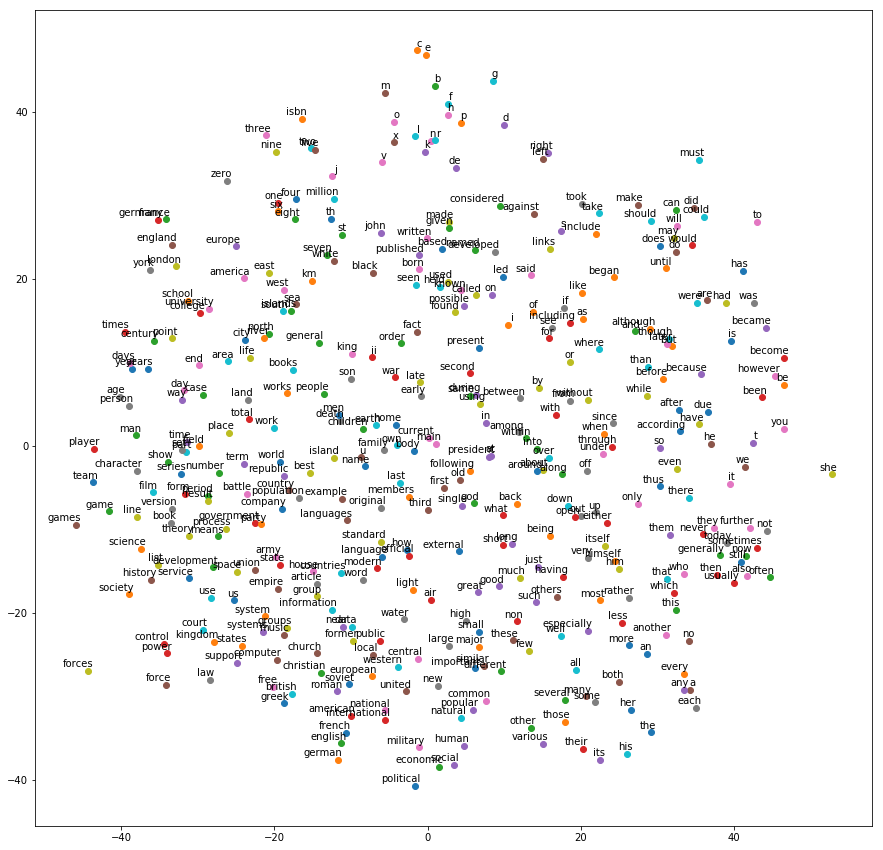

In [20]:
def plot(embeddings,labels):
    assert embeddings.shape[0]>=len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))
    for i,label in enumerate(labels):
        x,y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

## Problem

An alternative to skip-gram is another Word2Vec model called CBOW (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

Function to generate a training batch for the skip-gram model.

In [23]:
data_index = 0

def generate_batch(batch_size,bag_window):
    global data_index
    context_window = 2*bag_window+1
    batch = np.ndarray(shape=(batch_size,context_window-1), dtype=np.int32)
    label = np.ndarray(shape=(batch_size,1), dtype=np.int32)
    buffer = collections.deque(maxlen=context_window)
    for _ in range(context_window):
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    for i in range(batch_size):
        batch_list = list(buffer)
        label[i,0] = batch_list.pop(bag_window)
        batch[i]=batch_list
        buffer.append(data[data_index])
        data_index = (data_index+1)%len(data)
    return batch,label

print('data:', [reverse_dictionary[di] for di in data[:10]])

for bag_window in [(1), (2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print('\nwith context_window = %d and bag_window = %d:' % (2*bag_window+1, bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with context_window = 3 and bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with context_window = 5 and bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


In [27]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
bag_window = 1 # How many words to consider left and right.
context_window = 2 * bag_window+1
# num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 32 # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():
    
    train_dataset = tf.placeholder(tf.int32,shape=[batch_size,context_window-1])
    train_label = tf.placeholder(tf.int32,shape=[batch_size,1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    #Variables
    embeddings = tf.Variable(tf.random_uniform([Vocabulary_size,embedding_size],-1.0,1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([Vocabulary_size,embedding_size],stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([Vocabulary_size]))
    
    #Computation
    embed = tf.nn.embedding_lookup(embeddings,train_dataset)
    embed_context = tf.reduce_mean(embed, 1)
    #print(train_label.shape)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights,biases=softmax_biases,inputs=embed_context,
                               labels=train_label, num_sampled=num_sampled, num_classes=Vocabulary_size))
    
    #Optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embedding = embeddings/norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embedding,valid_dataset)
    similarity = tf.matmul(valid_embeddings,tf.transpose(normalized_embedding))

In [28]:
num_steps = 100001

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data,batch_label = generate_batch(batch_size,skip_window)
        feed_dict = {train_dataset: batch_data,train_label: batch_label}
        _, l  = sess.run([optimizer,loss], feed_dict = feed_dict)
        average_loss+=l
        if step%2000==0:
            if step>0:
                average_loss = average_loss/2000
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        if step%10000==0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embedding.eval()
                

Initialized
Average loss at step 0: 7.049801
Nearest to is: gravity, alcoholic, award, barcode, broadcasts, sidewinder, anything, languedoc,
Nearest to such: reverberation, incitement, yahweh, positive, extremely, eia, gut, complied,
Nearest to six: bazille, administratives, bestial, lib, affront, vibrating, rejuvenated, daddy,
Nearest to time: wahhabism, bengalis, beauharnais, amazon, sizes, overtook, feasibility, ers,
Nearest to when: obstructed, cam, plotted, journalism, caulfield, ck, emmy, sydney,
Nearest to war: smallpox, propagating, goldman, aurelius, dirty, macrophages, formulated, hildesheim,
Nearest to than: hormone, pedestrians, nassau, destroyed, reasonable, wollaston, mink, raid,
Nearest to UNK: babies, philia, credit, torn, dtp, apparently, deteriorating, marys,
Nearest to who: outrageous, originally, qua, brahmin, cliath, ged, escu, aloft,
Nearest to nine: subjective, tense, raiders, olney, hata, butterfield, authoritarian, rhapsody,
Nearest to eight: pubmed, actively, 

In [29]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

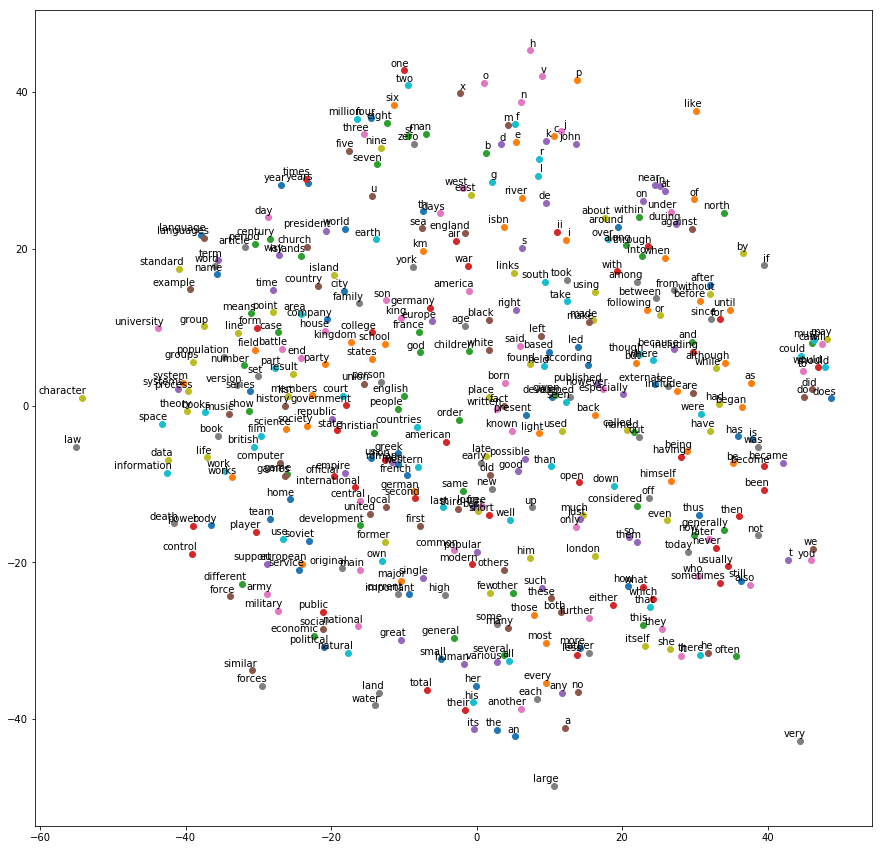

In [30]:
def plot(embeddings,labels):
    assert embeddings.shape[0]>=len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))
    for i,label in enumerate(labels):
        x,y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)